In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label]
        )
        model = vcat(
            ["JuloVelo" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "Blood progenitors 1" => "Blood progenitors 2",
    "Blood progenitors 2" => "Erythroid1",
    "Erythroid1" => "Erythroid2",
    "Erythroid2" => "Erythroid3"
)

Dict{String, String} with 4 entries:
  "Erythroid1"          => "Erythroid2"
  "Erythroid2"          => "Erythroid3"
  "Blood progenitors 1" => "Blood progenitors 2"
  "Blood progenitors 2" => "Erythroid1"

# Load data

In [8]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [9]:
julovelo_adata = readh5ad("data/JuloVelo.h5ad")
scvelo_adata = readh5ad("data/scvelo.h5ad")
deepvelo_adata = readh5ad("data/deepvelo.h5ad")
celldancer_adata = readh5ad("data/celldancer.h5ad")

AnnData object 9815 ✕ 1996

In [10]:
intrinsic_labels = sort(unique(julovelo_adata.obs.clusters))

5-element Vector{String}:
 "Blood progenitors 1"
 "Blood progenitors 2"
 "Erythroid1"
 "Erythroid2"
 "Erythroid3"

In [11]:
extrinsic_labels = [item for item in intrinsic_labels if item != "Erythroid3"]

4-element Vector{String}:
 "Blood progenitors 1"
 "Blood progenitors 2"
 "Erythroid1"
 "Erythroid2"

In [12]:
intrinsic_palettes = Dict("Blood progenitors 1"=>"#f9decf", 
    "Blood progenitors 2"=>"#c9a997", 
    "Erythroid1"=>"#C72228", 
    "Erythroid2"=>"#f79083", 
    "Erythroid3"=>"#EF4E22"
)

Dict{String, String} with 5 entries:
  "Erythroid1"          => "#C72228"
  "Erythroid3"          => "#EF4E22"
  "Erythroid2"          => "#f79083"
  "Blood progenitors 1" => "#f9decf"
  "Blood progenitors 2" => "#c9a997"

In [13]:
extrinsic_palettes = Dict("Blood progenitors 1"=>"#f9decf", 
    "Blood progenitors 2"=>"#c9a997", 
    "Erythroid1"=>"#C72228", 
    "Erythroid2"=>"#f79083"
)

Dict{String, String} with 4 entries:
  "Erythroid1"          => "#C72228"
  "Erythroid2"          => "#f79083"
  "Blood progenitors 1" => "#f9decf"
  "Blood progenitors 2" => "#c9a997"

In [15]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [17]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [18]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata)
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 5 entries:
  "Erythroid1"          => [-0.132445, 0.119601, 0.455897, 0.433992, 0.599739, …
  "Erythroid3"          => [0.652095, 0.663549, 0.648738, 0.887639, -0.330109, …
  "Erythroid2"          => [0.829462, 0.467725, 0.903585, 0.871472, 0.787717, 0…
  "Blood progenitors 1" => [0.821284, 0.650955, -0.362163, 0.676894, 0.999088, …
  "Blood progenitors 2" => [0.176861, 0.769303, -0.0557196, 0.241654, 0.970142,…

In [19]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, intrinsic_labels)

(Float32[-0.10722983, 0.74335927, 0.20130888, 0.73531073, -0.34168485, -0.3312801, 0.052982546, -0.054365546, 0.30714, 0.54515797  …  0.7086978, 0.55466866, 0.24675383, 0.5566271, 0.8682604, 0.8031326, 0.5590562, -0.23082468, 0.44988814, 0.5374258], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1"  …  "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3", "Erythroid3"])

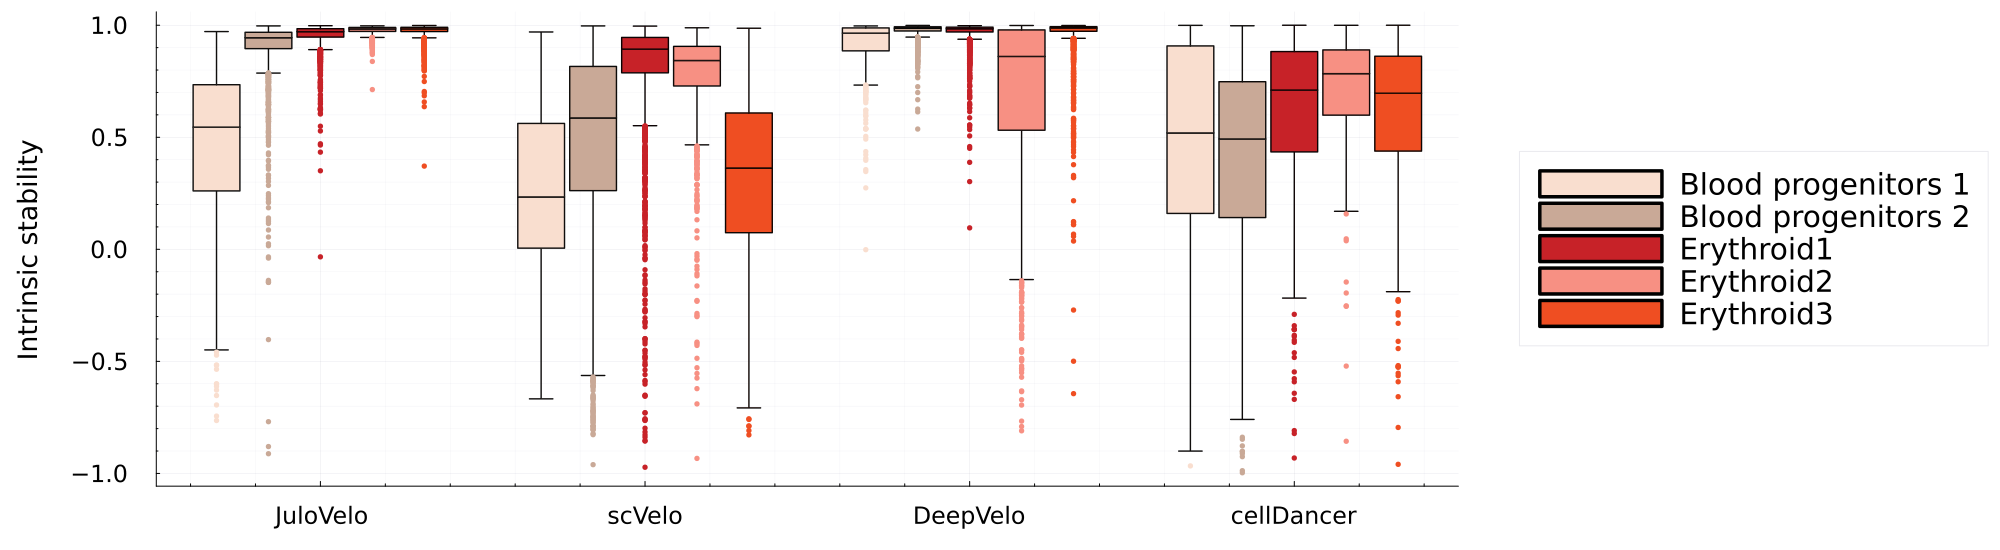

In [20]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [21]:
savefig(p, "figure/erythroid_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/erythroid/figure/erythroid_intrinsic_stability.png"

# Extrinsic stability

In [22]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction)
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr")

Dict{String, Vector{Float32}} with 4 entries:
  "Blood progenitors 2" => [0.168742, 0.354388, 0.847549, 0.0144726, -0.213661,…
  "Erythroid2"          => [0.816567, 0.453263, -0.126814, 0.977307, 0.347934, …
  "Blood progenitors 1" => [0.903129, -0.770859, -0.940002, -0.711642, 0.403034…
  "Erythroid1"          => [0.899931, 0.628923, 0.673488, 0.164199, 0.170247, -…

In [23]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, extrinsic_labels)

(Float32[0.7165172, 0.54288435, -0.9384049, 0.92564684, 0.8624703, 0.19088326, 0.8913027, 0.8605748, 0.5412291, -0.035649262  …  0.46776056, 0.7204072, 0.8228715, 0.64533556, -0.21217857, 0.7072217, 0.36264053, 0.27181122, 0.381763, -0.23260021], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer", "cellDancer"], Any["Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1", "Blood progenitors 1"  …  "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2", "Erythroid2"])

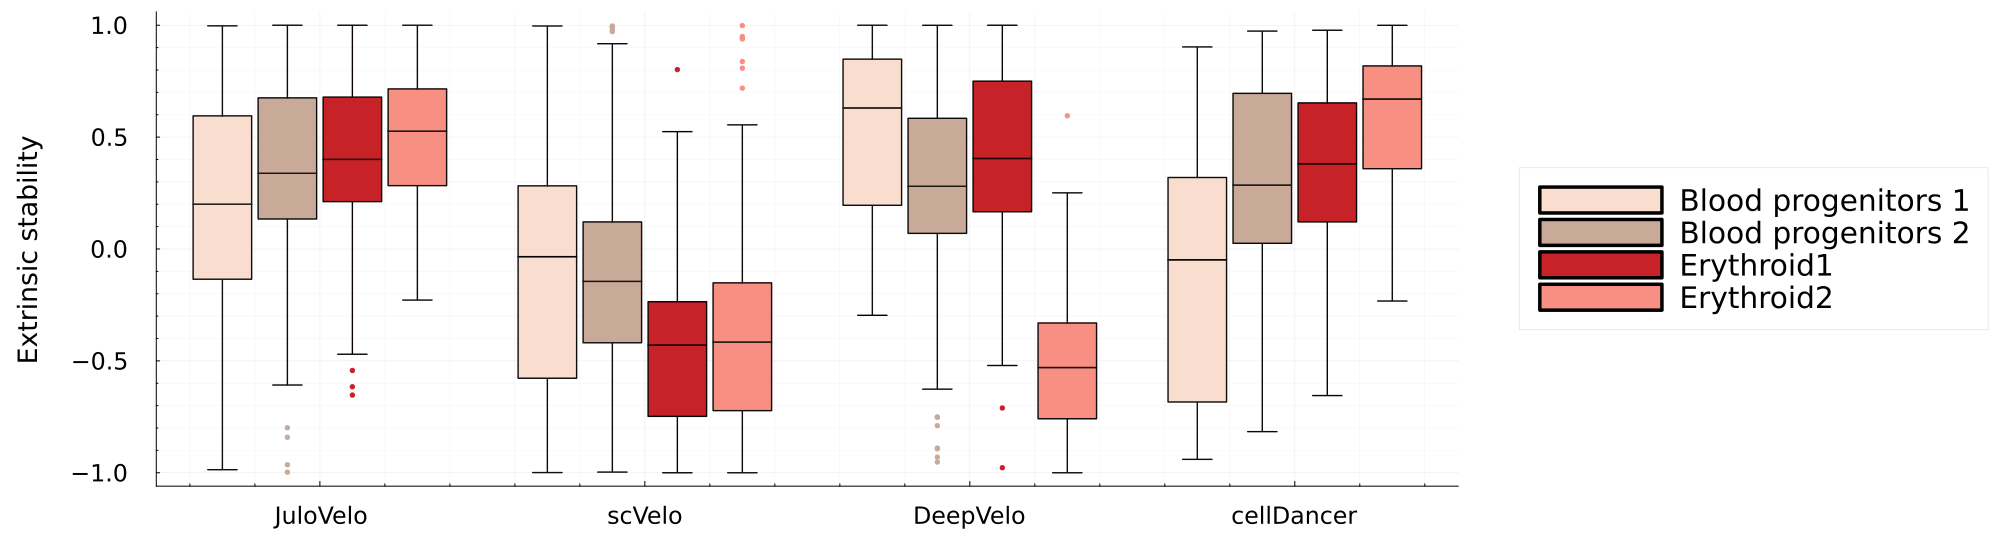

In [24]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [25]:
savefig(p, "figure/erythroid_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/erythroid/figure/erythroid_extrinsic_stability.png"